In [2]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Subset, TensorDataset
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import pandas as pd
# from collections import OrderedDict, defaultdict
# import torch.nn.functional as F

# # Model equations list
# model_equations = []

# # Loading UCI Heart Disease Dataset
# def load_uci_heart_disease():
#     url = "heart.csv"
#     # columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
#     df = pd.read_csv(url, na_values="?")
#     df = df.dropna()  # Drop rows with missing values
#     df.apply(pd.to_numeric, errors='coerce')


#     # Adjust the target to make it binary (0 for no heart disease, 1 for heart disease)
#     df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

#     return df

# # Fetching the dataset
# heart_data = load_uci_heart_disease()

# # Preprocessing the dataset
# feature_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
# X = heart_data[feature_columns].values
# y = heart_data['target'].values

# # Scaling features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Convert to tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# # Split data into 3 clients
# n_clients = 3
# client_data = [X_train_tensor[i * len(X_train_tensor) // n_clients: (i + 1) * len(X_train_tensor) // n_clients] for i in range(n_clients)]
# client_labels = [y_train_tensor[i * len(y_train_tensor) // n_clients: (i + 1) * len(y_train_tensor) // n_clients] for i in range(n_clients)]

# # Configuration class
# class Config:
#     def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=100, batch_size=16):
#         self.dropout = dropout
#         self.learning_rate = learning_rate
#         self.num_epochs = num_epochs
#         self.batch_size = batch_size

# # Define FeatureNN and NAM models (same as your original code)
# class FeatureNN(nn.Module):
#     def __init__(self, config, name, input_shape, num_units, feature_num):
#         super(FeatureNN, self).__init__()
#         self.config = config
#         self.name = name
#         self.input_shape = input_shape
#         self.num_units = num_units
#         self.feature_num = feature_num
#         self.fc = nn.Linear(input_shape, num_units)

#     def forward(self, x):
#         x = self.fc(x)
#         x = F.relu(x)
#         return x

# class NAM(nn.Module):
#     def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
#         super(NAM, self).__init__()
#         self.config = config
#         self.name = name
#         self.num_inputs = num_inputs
#         self.dropout = nn.Dropout(p=self.config.dropout)

#         if isinstance(num_units, list):
#             assert len(num_units) == num_inputs
#             self._num_units = num_units
#         elif isinstance(num_units, int):
#             self._num_units = [num_units for _ in range(self.num_inputs)]

#         self.feature_nns = nn.ModuleList([
#             FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
#             for i in range(num_inputs)
#         ])
#         self.output_layer = nn.Linear(sum(self._num_units), 2)  # 2 classes for binary classification
#         self._bias = torch.nn.Parameter(data=torch.zeros(1))

#     def calc_outputs(self, inputs: torch.Tensor):
#         return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self.num_inputs)]

#     def forward(self, inputs: torch.Tensor):
#         individual_outputs = self.calc_outputs(inputs)
#         conc_out = torch.cat(individual_outputs, dim=-1)
#         dropout_out = self.dropout(conc_out)
#         out = self.output_layer(dropout_out)
#         return out, dropout_out

#     def print_model_equation(self, feature_names):
#         equation_terms = []
#         feature_contributions = {}
#         for i, fnn in enumerate(self.feature_nns):
#             coefficients = fnn.fc.weight.data.flatten().tolist()
#             intercepts = fnn.fc.bias.data.tolist()
#             term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
#             equation_terms.append(term)
#             feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
#         equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
#         print(f"Model Equation: y = {equation}")
#         model_equations.append(equation)
#         interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
#         print("\nFeature Contributions:")
#         for feature, contribution in interpretability:
#             print(f"{feature}: {contribution:.3f}")

#         return interpretability[0][0], interpretability[-1][0]

# # Model training and evaluation functions
# def train(model, X_train, y_train, config):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
#     model.train()
#     for epoch in range(config.num_epochs):
#         outputs, _ = model(X_train)
#         optimizer.zero_grad()
#         loss = criterion(outputs, y_train)
#         loss.backward()
#         optimizer.step()
#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {loss.item():.4f}')
#     return model

# def evaluate(model, X_test, y_test):
#     model.eval()
#     with torch.no_grad():
#         outputs, _ = model(X_test)
#         _, predicted = torch.max(outputs, 1)
#         accuracy = (predicted == y_test).sum().item() / y_test.size(0)
#         print(f'Accuracy: {accuracy * 100:.2f}%')

# # Train and evaluate model for each client
# clients_features1 = {}
# clients_features2 = {}
# for i in range(n_clients):
#     config = Config(dropout=0.5, learning_rate=0.001, num_epochs=70, batch_size=16)
#     num_inputs = len(feature_columns)  # Number of features
#     num_units = 10  # Number of units in the hidden layer
#     nam_model = NAM(config=config, name=f'NAM_Model_Client_{i+1}', num_inputs=num_inputs, num_units=num_units)

#     # Train the model for the client
#     trained_model = train(nam_model, client_data[i], client_labels[i], config)

#     # Evaluate the model
#     evaluate(trained_model, X_test_tensor, y_test_tensor)

#     # Print the model equation and get the most and least contributing features
#     most_contributing_feature, least_contributing_feature = trained_model.print_model_equation(feature_columns)
#     clients_features1[i] = most_contributing_feature
#     clients_features2[i] = least_contributing_feature
#     print(f"\nMost contributing feature for client {i+1}: {most_contributing_feature}")
#     print(f"Least contributing feature for client {i+1}: {least_contributing_feature}")


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import OrderedDict, defaultdict
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_auc_score
import itertools

# Model equations list
model_equations = []

# Loading UCI Heart Disease Dataset
def load_uci_heart_disease():
    url = "heart.csv"
    df = pd.read_csv(url, na_values="?")
    df = df.dropna()  # Drop rows with missing values
    df.apply(pd.to_numeric, errors='coerce')
    # Adjust the target to make it binary (0 for no heart disease, 1 for heart disease)
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    return df

# Fetching the dataset
heart_data = load_uci_heart_disease()

# Preprocessing the dataset
feature_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X = heart_data[feature_columns].values
y = heart_data['target'].values

# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Split data into 3 clients
n_clients = 3
client_data = [X_train_tensor[i * len(X_train_tensor) // n_clients: (i + 1) * len(X_train_tensor) // n_clients] for i in range(n_clients)]
client_labels = [y_train_tensor[i * len(y_train_tensor) // n_clients: (i + 1) * len(y_train_tensor) // n_clients] for i in range(n_clients)]

# Configuration class
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=100, batch_size=16, patience=15):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.patience = patience

# Define FeatureNN and NAM models
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

class NAM(nn.Module):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__()
        self.config = config
        self.name = name
        self.num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self.num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])
        self.output_layer = nn.Linear(sum(self._num_units), 2)  # 2 classes for binary classification
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor):
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self.num_inputs)]

    def forward(self, inputs: torch.Tensor):
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")
        model_equations.append(equation)
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")

        return interpretability[0][0], interpretability[-1][0]

# Custom weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Early stopping function
def early_stopping(val_loss, best_loss, stop_counter, patience):
    if val_loss < best_loss:
        best_loss = val_loss
        stop_counter = 0
    else:
        stop_counter += 1
    if stop_counter >= patience:
        print("Early stopping triggered!")
        return True, best_loss, stop_counter
    return False, best_loss, stop_counter

# Model training and evaluation functions with early stopping and scheduler
def train(model, train_loader, val_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    model.apply(init_weights)  # Apply custom weight initialization
    model.train()

    best_loss = float('inf')
    stop_counter = 0
    for epoch in range(config.num_epochs):
        total_loss = 0
        model.train()
        for X_batch, y_batch in train_loader:
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs, _ = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early stopping check
        stop, best_loss, stop_counter = early_stopping(val_loss, best_loss, stop_counter, config.patience)
        if stop:
            break
        
        scheduler.step()  # Update learning rate

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}')
    return model

def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs, _ = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        print(f'Accuracy: {accuracy * 100:.2f}%')
        # More detailed metrics
        report = classification_report(y_test, predicted)
        auc = roc_auc_score(y_test, predicted)
        print(f"Classification Report:\n{report}")
        print(f"ROC-AUC: {auc:.2f}")

# Hyperparameter tuning setup
dropouts = [0.3, 0.5]
learning_rates = [0.001, 0.0001]
num_units_list = [10]
batch_size = [16,32]


best_accuracy = 0.0
best_params = None

clients_features1 = {}
clients_features2 = {}

for dropout, lr, num_units, bs in itertools.product(dropouts, learning_rates, num_units_list, batch_size):
    print(f"Tuning with dropout={dropout}, learning_rate={lr}, num_units={num_units}, batch_size={bs}")
    for i in range(n_clients):
        config = Config(dropout=dropout, learning_rate=lr, num_epochs=100, batch_size=bs, patience=15)
        num_inputs = len(feature_columns)  # Number of features
        nam_model = NAM(config=config, name=f'NAM_Model_Client_{i+1}', num_inputs=num_inputs, num_units=num_units)
        
        # Create DataLoader for each client
        train_dataset = TensorDataset(client_data[i], client_labels[i])
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=config.batch_size)

        # Train the model with early stopping and scheduler
        trained_model = train(nam_model, train_loader, val_loader, config)

        # Evaluate the model
        evaluate(trained_model, X_test_tensor, y_test_tensor)
        accuracy = (trained_model(X_test_tensor)[0].argmax(dim=1) == y_test_tensor).float().mean().item()
        
        # Track best hyperparameters based on accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (dropout, lr, num_units, bs)

        # Print the model equation and get the most and least contributing features
        most_contributing_feature, least_contributing_feature = trained_model.print_model_equation(feature_columns)
        clients_features1[i] = most_contributing_feature
        clients_features2[i] = least_contributing_feature
        print(f"\nMost contributing feature for client {i+1}: {most_contributing_feature}")
        print(f"Least contributing feature for client {i+1}: {least_contributing_feature}")

# Print the best hyperparameters
print(f"\nBest Hyperparameters: Dropout: {best_params[0]}, Learning Rate: {best_params[1]}, Num Units: {best_params[2]},batch size: {best_params[3]}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")


Tuning with dropout=0.3, learning_rate=0.001, num_units=10, batch_size=16
Epoch [10/100], Loss: 0.3869, Val Loss: 0.4321
Epoch [20/100], Loss: 0.3188, Val Loss: 0.4012
Epoch [30/100], Loss: 0.3358, Val Loss: 0.4022
Early stopping triggered!
Accuracy: 82.79%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       159
           1       0.77      0.92      0.84       149

    accuracy                           0.83       308
   macro avg       0.84      0.83      0.83       308
weighted avg       0.84      0.83      0.83       308

ROC-AUC: 0.83
Model Equation: y = (0.699 * x_age + 0.041) + (-0.259 * x_age + -0.055) + (0.604 * x_age + -0.076) + (-0.751 * x_age + 0.059) + (0.649 * x_age + 0.062) + (-0.585 * x_age + 0.086) + (-0.624 * x_age + -0.068) + (-0.511 * x_age + 0.091) + (0.465 * x_age + -0.086) + (0.598 * x_age + -0.087) + (0.620 * x_sex + -0.063) + (0.083 * x_sex + 0.072) + (0.445 * x_sex + 0.052) + (-0.448 *

# Plots

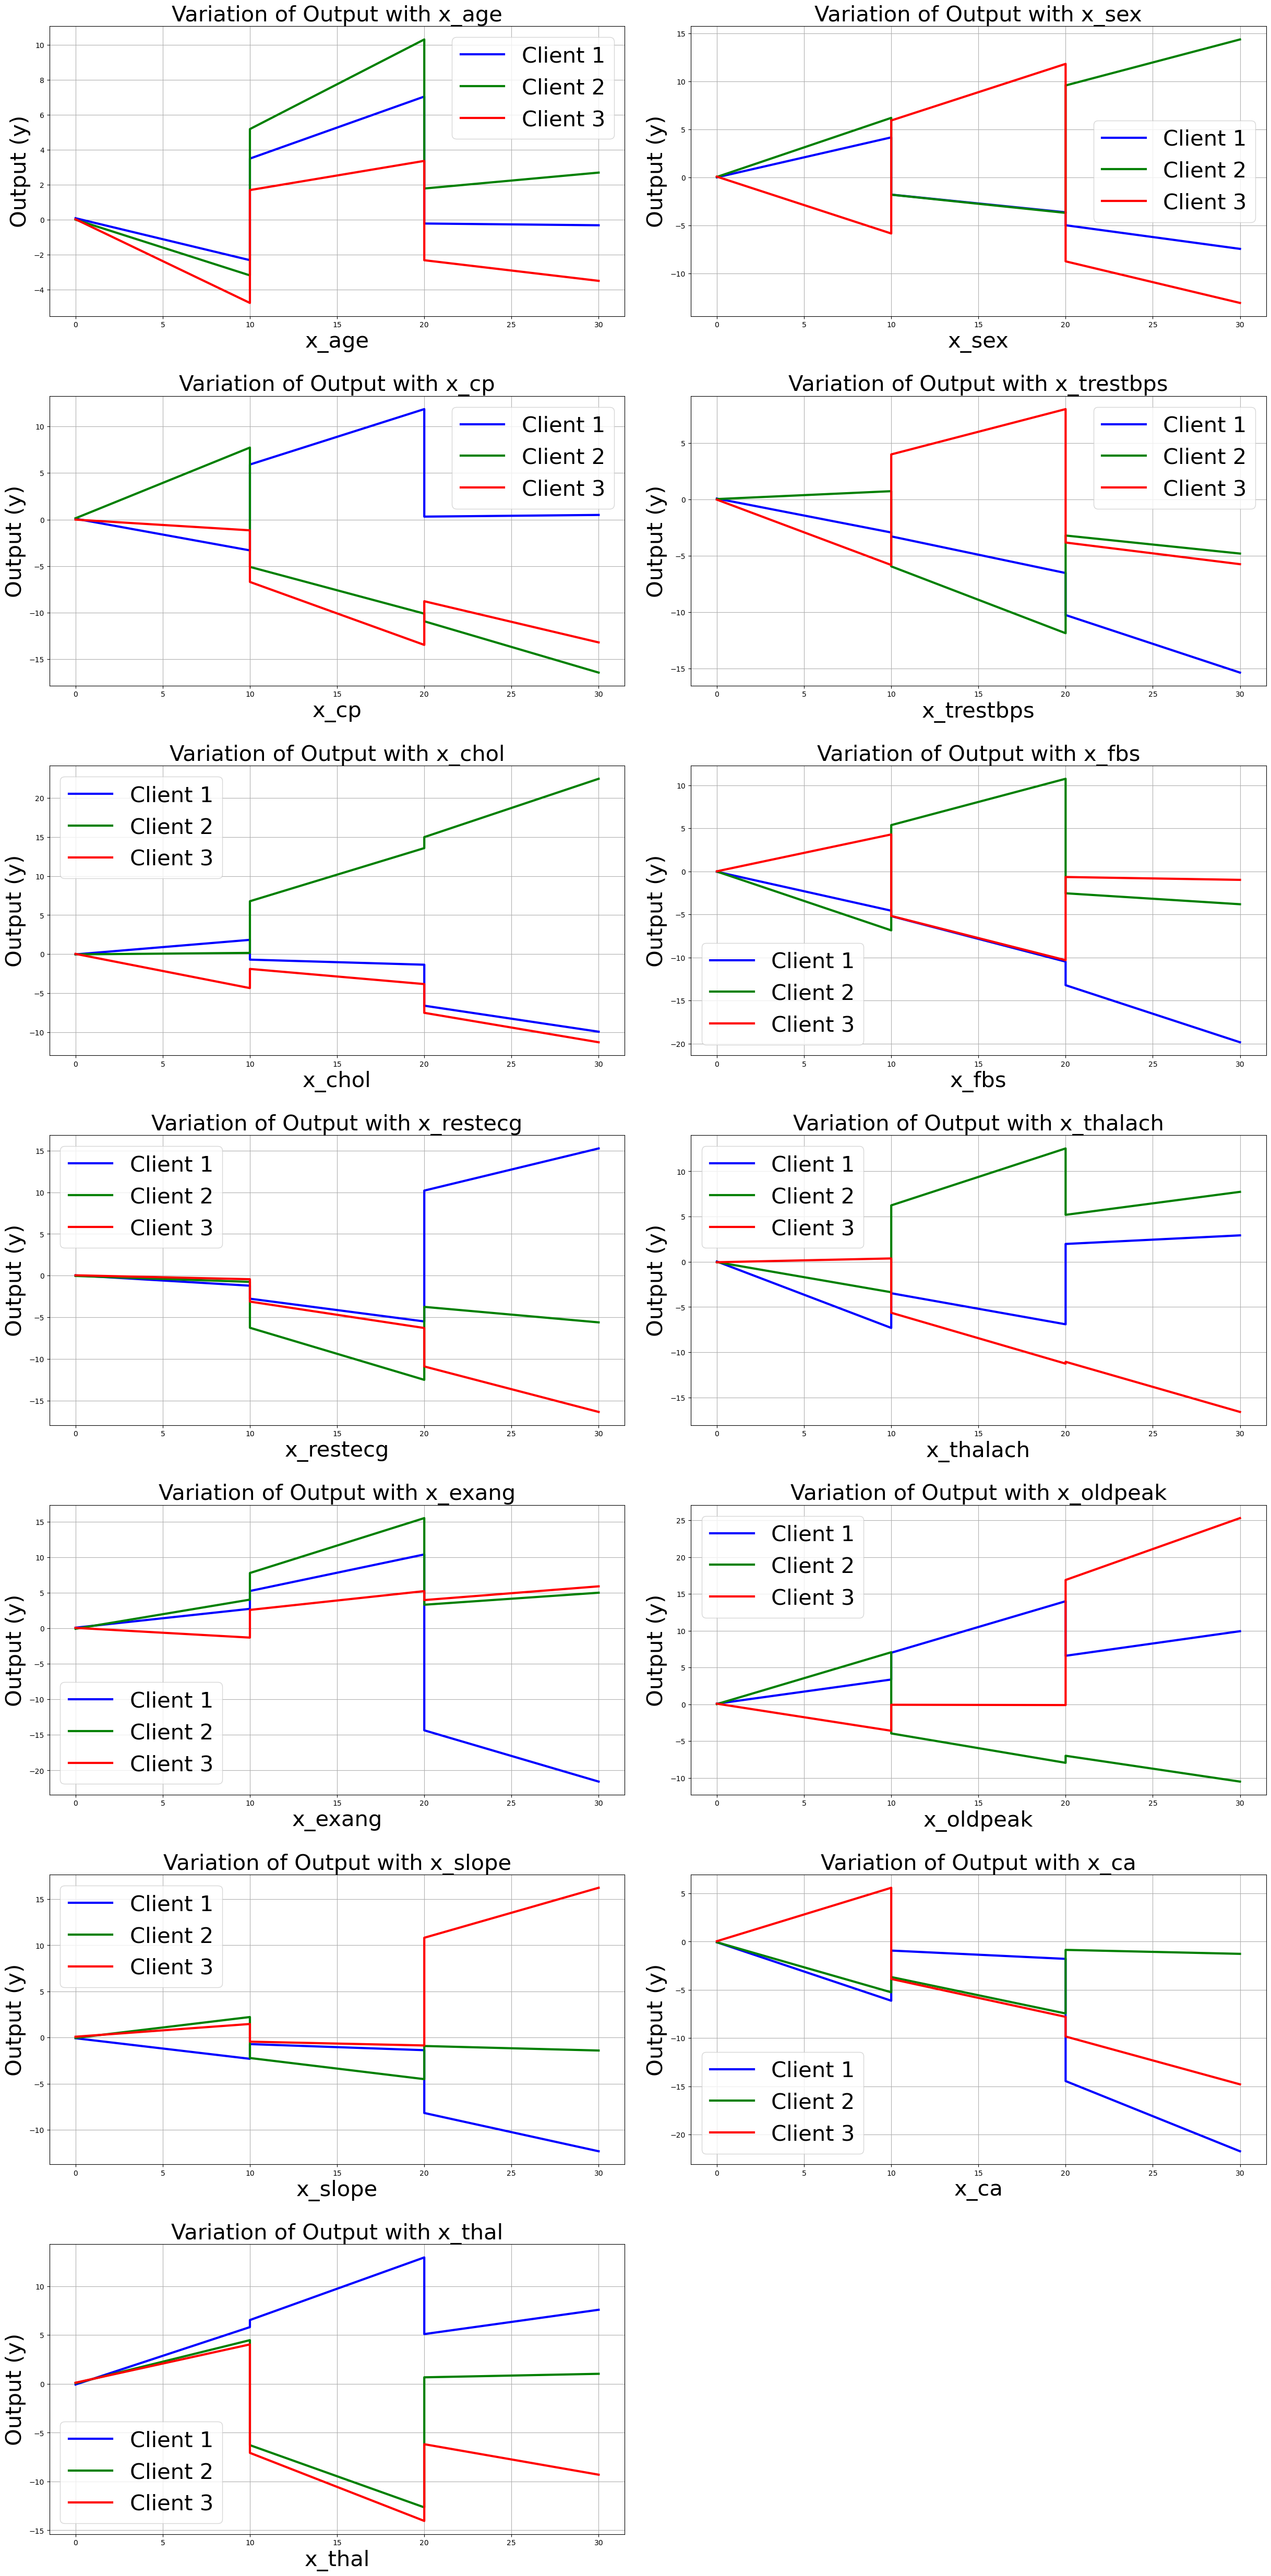

In [24]:
# Function to plot equations for a given range of indices and connect lines with increased font size
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color,linewidth=3)
    ax.set_xlabel(feature_name, fontsize=30)  # Increased font size for x label
    ax.set_ylabel('Output (y)', fontsize=30)  # Increased font size for y label
    ax.grid(True)
    ax.legend(fontsize=30)


# Defining coefficients and intercepts for all 14 features for each client based on the provided model equations

coefficients_client1 = {
    'x_age': [-0.240, 0.355, -0.010, -0.015, 0.543, -0.799, -0.793, 0.480, -0.623, -0.239],
    'x_sex': [0.416, -0.184, -0.246, 0.262, 0.352, 0.165, 0.711, 0.313, 0.420, -0.515],
    'x_cp': [-0.340, 0.595, 0.018, -0.244, 0.672, 0.002, -0.385, -0.278, -0.571, -0.573],
    'x_trestbps': [-0.301, -0.325, -0.511, 0.467, -0.628, 0.069, 0.621, 0.132, -0.297, -0.206],
    'x_chol': [0.186, -0.065, -0.333, 0.558, 0.124, 0.210, -0.015, -0.061, -0.600, 0.030],
    'x_fbs': [-0.452, -0.528, -0.663, 0.129, -0.148, 0.539, -0.088, 0.513, -0.141, 0.172],
    'x_restecg': [-0.124, -0.273, 0.506, 0.437, -0.300, 0.330, 0.238, 0.165, -0.704, 0.175],
    'x_thalach': [-0.734, -0.343, 0.095, -0.235, -0.722, -0.774, 0.475, -0.539, 0.324, -0.247],
    'x_exang': [0.265, 0.514, -0.721, 0.166, -0.060, 0.037, 0.015, 0.723, -0.104, -0.320],
    'x_oldpeak': [0.328, 0.700, 0.334, 0.157, -0.067, -0.261, -0.486, -0.232, 0.614, -0.207],
    'x_slope': [-0.223, -0.066, -0.415, 0.013, -0.613, -0.280, 0.011, 0.542, -0.171, 0.443],
    'x_ca': [-0.606, -0.086, -0.728, 0.593, 0.391, 0.028, 0.570, -0.379, 0.163, 0.294],
    'x_thal': [0.588, 0.641, 0.249, 0.724, -0.614, -0.129, -0.476, 0.631, 0.030, -0.279]
}

intercepts_client1 = {
    'x_age': [0.080, -0.057, -0.023, -0.038, -0.031, 0.092, 0.077, 0.025, 0.069, 0.067],
    'x_sex': [-0.002, 0.041, -0.067, -0.024, 0.014, 0.023, -0.015, -0.020, 0.030, -0.043],
    'x_cp': [0.089, -0.042, -0.045, 0.089, 0.047, -0.018, 0.104, 0.064, 0.109, 0.093],
    'x_trestbps': [0.061, -0.046, -0.053, -0.019, 0.045, -0.034, -0.035, -0.019, 0.056, -0.046],
    'x_chol': [-0.032, -0.055, 0.056, 0.011, 0.015, -0.037, -0.016, -0.054, -0.000, -0.007],
    'x_fbs': [-0.050, 0.077, 0.041, -0.010, 0.047, -0.023, -0.039, 0.004, -0.035, 0.002],
    'x_restecg': [0.024, -0.047, 0.080, 0.060, -0.058, -0.065, 0.079, 0.087, -0.026, 0.066],
    'x_thalach': [0.033, -0.045, 0.071, 0.054, 0.036, 0.036, -0.061, -0.060, 0.101, -0.008],
    'x_exang': [0.079, 0.097, 0.063, -0.076, -0.055, -0.062, -0.035, 0.061, -0.070, 0.075],
    'x_oldpeak': [0.093, 0.013, -0.079, -0.081, -0.065, 0.084, -0.085, 0.102, -0.060, 0.116],
    'x_slope': [-0.079, -0.054, 0.116, -0.028, -0.033, -0.082, -0.024, -0.086, 0.104, -0.076],
    'x_ca': [-0.071, -0.070, 0.097, 0.071, 0.080, -0.033, 0.093, 0.105, -0.065, 0.089],
    'x_thal': [-0.071, 0.124, 0.115, 0.088, -0.009, -0.068, 0.150, -0.016, -0.043, 0.116]
}


coefficients_client2 = {
    'x_age': [-0.319, 0.513, 0.091, 0.726, -0.489, -0.331, 0.215, 0.343, 0.106, 0.516],
    'x_sex': [0.615, -0.189, 0.479, -0.125, 0.537, -0.654, 0.019, 0.237, 0.036, 0.759],
    'x_cp': [0.759, -0.502, -0.551, 0.222, 0.001, 0.575, -0.478, 0.728, 0.274, -0.595],
    'x_trestbps': [0.070, -0.593, -0.160, 0.735, 0.212, -0.521, 0.581, -0.291, -0.016, -0.654],
    'x_chol': [0.019, 0.680, 0.747, 0.216, -0.002, -0.764, -0.051, 0.636, -0.510, 0.109],
    'x_fbs': [-0.683, 0.538, -0.127, 0.337, 0.049, 0.031, -0.110, 0.017, 0.198, 0.523],
    'x_restecg': [-0.071, -0.625, -0.186, 0.626, -0.287, 0.215, 0.657, 0.461, 0.024, -0.552],
    'x_thalach': [-0.333, 0.629, 0.254, 0.686, 0.445, 0.383, -0.692, 0.552, 0.784, -0.468],
    'x_exang': [0.410, 0.772, 0.169, -0.189, -0.197, 0.589, 0.532, -0.144, -0.273, -0.652],
    'x_oldpeak': [0.705, -0.399, -0.351, -0.760, -0.337, 0.009, -0.688, -0.084, -0.618, 0.470],
    'x_slope': [0.227, -0.229, -0.049, -0.173, -0.315, -0.016, -0.548, 0.065, -0.722, -0.361],
    'x_ca': [-0.519, -0.378, -0.041, 0.445, -0.556, -0.440, -0.358, 0.330, 0.648, -0.325],
    'x_thal': [0.441, -0.637, 0.036, -0.030, 0.484, 0.352, -0.657, 0.177, 0.484, -0.117]
}


intercepts_client2 = {
    'x_age': [-0.002, 0.052, -0.039, 0.057, -0.055, -0.056, 0.036, 0.060, 0.046, 0.026],
    'x_sex': [0.040, 0.081, -0.017, -0.039, -0.057, 0.069, -0.019, -0.018, -0.032, 0.042],
    'x_cp': [0.139, -0.061, 0.098, 0.120, -0.015, -0.069, -0.022, 0.125, -0.005, 0.100],
    'x_trestbps': [0.016, -0.027, -0.019, -0.018, -0.004, -0.001, -0.006, -0.012, 0.000, -0.007],
    'x_chol': [-0.032, -0.026, 0.042, 0.044, -0.008, 0.072, -0.039, -0.052, 0.062, -0.062],
    'x_fbs': [-0.023, -0.010, -0.008, 0.007, 0.012, -0.004, -0.002, 0.003, -0.017, -0.012],
    'x_restecg': [-0.047, -0.017, -0.039, -0.039, 0.050, -0.066, 0.006, -0.036, -0.016, -0.049],
    'x_thalach': [-0.034, -0.055, 0.108, -0.043, 0.072, 0.087, 0.071, 0.081, 0.093, 0.093],
    'x_exang': [-0.077, 0.048, -0.075, -0.060, -0.076, -0.062, 0.120, 0.036, 0.076, 0.009],
    'x_oldpeak': [0.032, 0.035, 0.031, 0.037, 0.052, -0.026, -0.028, -0.050, -0.060, 0.064],
    'x_slope': [-0.050, 0.066, 0.059, 0.080, 0.054, 0.029, 0.051, -0.039, 0.046, 0.066],
    'x_ca': [-0.067, 0.106, -0.039, 0.171, 0.153, -0.083, 0.126, 0.161, -0.087, 0.109],
    'x_thal': [0.063, 0.092, -0.052, -0.041, 0.125, 0.130, 0.103, 0.092, 0.093, -0.060]
}


coefficients_client3 = {
    'x_age': [-0.479, 0.167, -0.118, -0.687, -0.183, -0.669, -0.215, -0.088, 0.321, -0.436],
    'x_sex': [-0.592, 0.589, -0.433, 0.177, -0.370, 0.696, -0.568, -0.450, -0.587, -0.166],
    'x_cp': [-0.115, -0.676, -0.442, -0.331, 0.253, 0.134, 0.452, -0.430, 0.149, -0.277],
    'x_trestbps': [-0.580, 0.402, -0.192, -0.398, -0.194, -0.604, -0.343, -0.650, 0.255, 0.178],
    'x_chol': [-0.438, -0.194, -0.377, -0.351, 0.146, -0.586, -0.364, 0.272, -0.618, 0.219],
    'x_fbs': [0.428, -0.514, -0.033, -0.124, 0.094, 0.510, -0.414, -0.195, -0.344, -0.295],
    'x_restecg': [-0.047, -0.317, -0.546, 0.220, -0.657, -0.537, -0.641, -0.173, -0.143, -0.001],
    'x_thalach': [0.042, -0.562, -0.554, 0.268, -0.558, 0.250, -0.003, 0.613, 0.393, -0.132],
    'x_exang': [-0.137, 0.264, 0.193, -0.526, 0.604, 0.002, 0.175, 0.570, -0.517, -0.639],
    'x_oldpeak': [-0.368, -0.004, 0.841, 0.214, -0.344, -0.535, -0.614, 0.328, 0.703, -0.245],
    'x_slope': [0.138, -0.041, 0.542, 0.132, -0.658, 0.429, 0.174, 0.481, -0.312, -0.357],
    'x_ca': [0.554, -0.393, -0.496, 0.424, 0.624, 0.526, 0.271, -0.694, -0.114, -0.150],
    'x_thal': [0.392, -0.697, -0.312, 0.096, 0.511, 0.445, 0.765, 0.382, 0.588, -0.110]
}

intercepts_client3 = {
    'x_age': [0.021, 0.021, 0.036, 0.018, 0.021, 0.023, -0.038, 0.043, -0.052, 0.039],
    'x_sex': [0.072, 0.029, -0.086, -0.048, 0.105, 0.034, 0.079, -0.001, 0.054, 0.066],
    'x_cp': [-0.006, 0.063, 0.070, 0.070, -0.046, -0.065, -0.069, -0.034, 0.136, 0.061],
    'x_trestbps': [-0.034, -0.041, -0.001, 0.001, -0.007, 0.012, -0.004, -0.019, -0.033, -0.037],
    'x_chol': [0.031, 0.045, 0.024, -0.048, 0.027, 0.038, 0.025, 0.042, 0.001, -0.022],
    'x_fbs': [0.006, -0.038, 0.002, 0.000, 0.001, -0.035, -0.010, -0.006, -0.002, -0.006],
    'x_restecg': [0.030, 0.044, 0.009, -0.038, -0.040, 0.041, 0.020, -0.029, -0.025, -0.004],
    'x_thalach': [-0.049, -0.013, 0.030, 0.038, -0.048, 0.049, -0.023, 0.004, 0.017, 0.079],
    'x_exang': [0.053, -0.060, 0.102, 0.054, 0.068, -0.024, -0.074, -0.083, 0.055, 0.061],
    'x_oldpeak': [0.089, -0.017, 0.081, -0.057, 0.065, 0.066, -0.015, -0.049, 0.117, 0.067],
    'x_slope': [0.086, -0.042, -0.025, 0.082, -0.071, 0.094, 0.017, -0.066, -0.076, 0.088],
    'x_ca': [0.043, 0.057, 0.078, 0.062, -0.072, 0.076, 0.094, 0.056, 0.029, -0.052],
    'x_thal': [0.117, -0.097, 0.058, -0.061, 0.082, 0.068, 0.083, 0.095, 0.002, 0.078]
}


# Features to plot
features = [
    'x_age', 'x_sex', 'x_cp', 'x_trestbps', 'x_chol', 'x_fbs', 'x_restecg',
    'x_thalach', 'x_exang', 'x_oldpeak', 'x_slope', 'x_ca', 'x_thal'
]
# Adjusting the number of rows and columns based on the number of features
n_cols = 2  # Number of columns
n_features = len(features)  # Total number of features
n_rows = math.ceil(n_features / n_cols)  # Dynamically calculate the number of rows

# Create subplots based on the dynamic number of rows
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 50))  # Adjust the figure size
axs = axs.flatten()  # Flatten the axes to easily iterate through

# Client data
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']

# Loop through all features and plot
for i, feature in enumerate(features):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(3), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(3), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(3), clients[2], colors[2])
    axs[i].set_title(f'Variation of Output with {feature}', fontsize=30)  # Updated title with feature name
    axs[i].set_ylabel('Output (y)', fontsize=30)  # Added y-label

# Remove the last empty subplot if the number of features is odd
if n_features % n_cols != 0:
    fig.delaxes(axs[-1])

plt.tight_layout(pad=3.0)
plt.savefig("uci_heart_fednam.pdf", dpi=600)
plt.show()



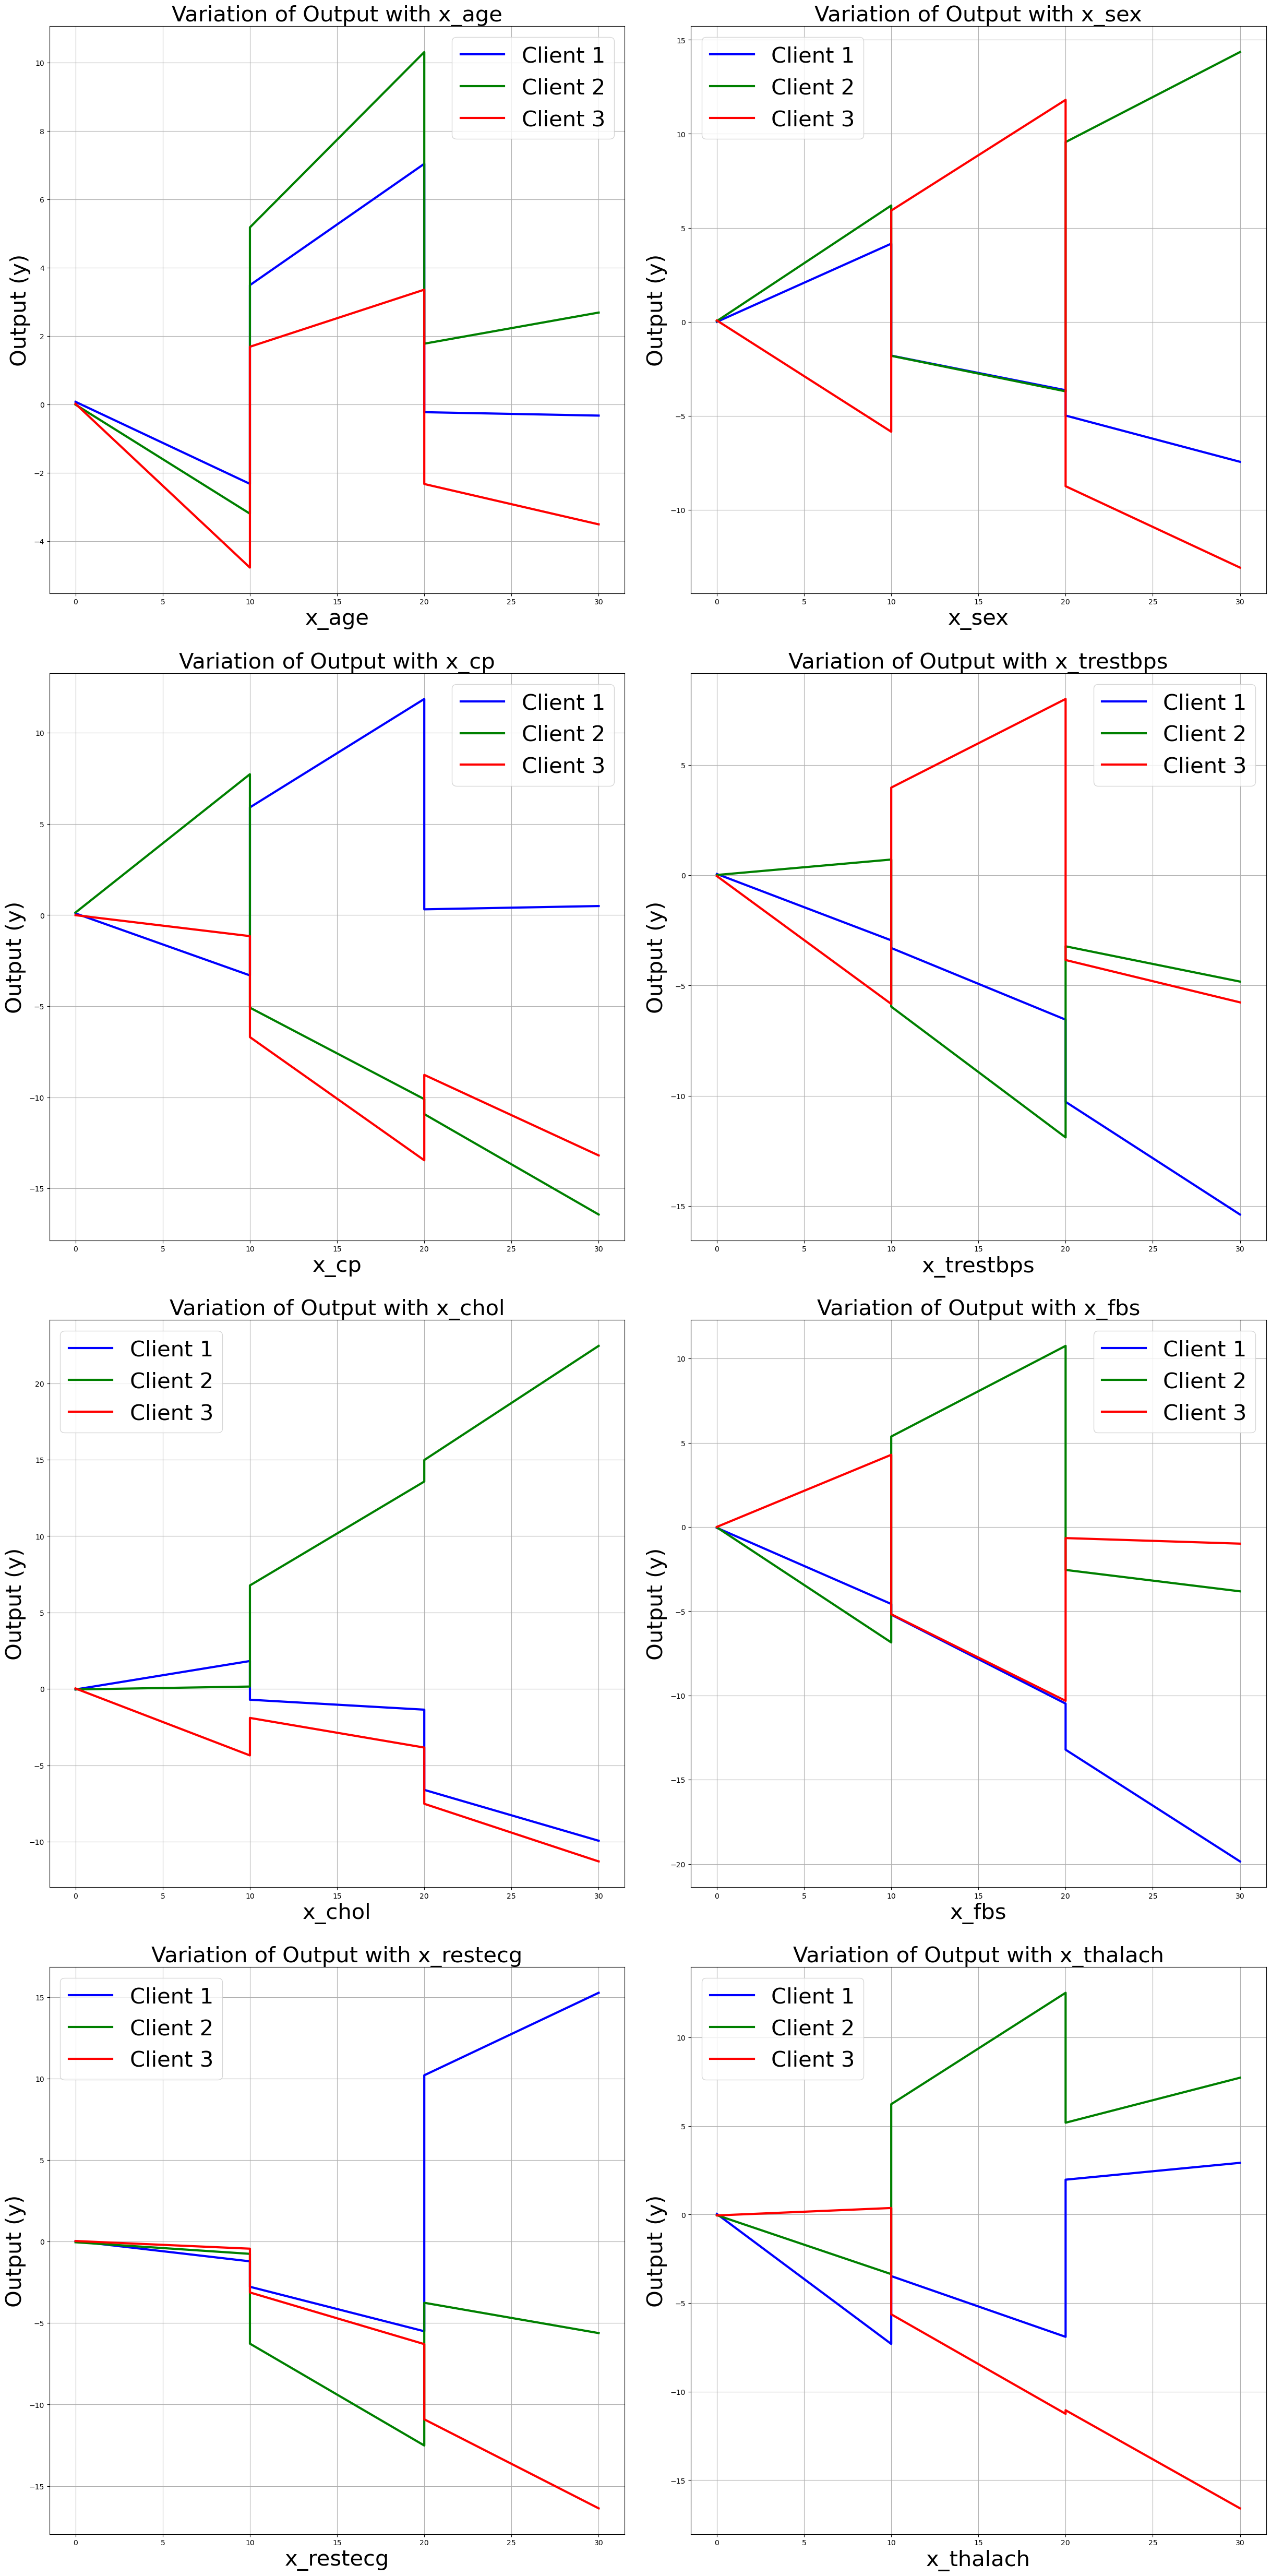

In [25]:
# Function to plot equations for a given range of indices and connect lines with increased font size
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color,linewidth=3)
    ax.set_xlabel(feature_name, fontsize=30)  # Increased font size for x label
    ax.set_ylabel('Output (y)', fontsize=30)  # Increased font size for y label
    ax.grid(True)
    ax.legend(fontsize=30)


# Defining coefficients and intercepts for all 14 features for each client based on the provided model equations

coefficients_client1 = {
    'x_age': [-0.240, 0.355, -0.010, -0.015, 0.543, -0.799, -0.793, 0.480, -0.623, -0.239],
    'x_sex': [0.416, -0.184, -0.246, 0.262, 0.352, 0.165, 0.711, 0.313, 0.420, -0.515],
    'x_cp': [-0.340, 0.595, 0.018, -0.244, 0.672, 0.002, -0.385, -0.278, -0.571, -0.573],
    'x_trestbps': [-0.301, -0.325, -0.511, 0.467, -0.628, 0.069, 0.621, 0.132, -0.297, -0.206],
    'x_chol': [0.186, -0.065, -0.333, 0.558, 0.124, 0.210, -0.015, -0.061, -0.600, 0.030],
    'x_fbs': [-0.452, -0.528, -0.663, 0.129, -0.148, 0.539, -0.088, 0.513, -0.141, 0.172],
    'x_restecg': [-0.124, -0.273, 0.506, 0.437, -0.300, 0.330, 0.238, 0.165, -0.704, 0.175],
    'x_thalach': [-0.734, -0.343, 0.095, -0.235, -0.722, -0.774, 0.475, -0.539, 0.324, -0.247],
}

intercepts_client1 = {
    'x_age': [0.080, -0.057, -0.023, -0.038, -0.031, 0.092, 0.077, 0.025, 0.069, 0.067],
    'x_sex': [-0.002, 0.041, -0.067, -0.024, 0.014, 0.023, -0.015, -0.020, 0.030, -0.043],
    'x_cp': [0.089, -0.042, -0.045, 0.089, 0.047, -0.018, 0.104, 0.064, 0.109, 0.093],
    'x_trestbps': [0.061, -0.046, -0.053, -0.019, 0.045, -0.034, -0.035, -0.019, 0.056, -0.046],
    'x_chol': [-0.032, -0.055, 0.056, 0.011, 0.015, -0.037, -0.016, -0.054, -0.000, -0.007],
    'x_fbs': [-0.050, 0.077, 0.041, -0.010, 0.047, -0.023, -0.039, 0.004, -0.035, 0.002],
    'x_restecg': [0.024, -0.047, 0.080, 0.060, -0.058, -0.065, 0.079, 0.087, -0.026, 0.066],
    'x_thalach': [0.033, -0.045, 0.071, 0.054, 0.036, 0.036, -0.061, -0.060, 0.101, -0.008],
}


coefficients_client2 = {
    'x_age': [-0.319, 0.513, 0.091, 0.726, -0.489, -0.331, 0.215, 0.343, 0.106, 0.516],
    'x_sex': [0.615, -0.189, 0.479, -0.125, 0.537, -0.654, 0.019, 0.237, 0.036, 0.759],
    'x_cp': [0.759, -0.502, -0.551, 0.222, 0.001, 0.575, -0.478, 0.728, 0.274, -0.595],
    'x_trestbps': [0.070, -0.593, -0.160, 0.735, 0.212, -0.521, 0.581, -0.291, -0.016, -0.654],
    'x_chol': [0.019, 0.680, 0.747, 0.216, -0.002, -0.764, -0.051, 0.636, -0.510, 0.109],
    'x_fbs': [-0.683, 0.538, -0.127, 0.337, 0.049, 0.031, -0.110, 0.017, 0.198, 0.523],
    'x_restecg': [-0.071, -0.625, -0.186, 0.626, -0.287, 0.215, 0.657, 0.461, 0.024, -0.552],
    'x_thalach': [-0.333, 0.629, 0.254, 0.686, 0.445, 0.383, -0.692, 0.552, 0.784, -0.468],
}


intercepts_client2 = {
    'x_age': [-0.002, 0.052, -0.039, 0.057, -0.055, -0.056, 0.036, 0.060, 0.046, 0.026],
    'x_sex': [0.040, 0.081, -0.017, -0.039, -0.057, 0.069, -0.019, -0.018, -0.032, 0.042],
    'x_cp': [0.139, -0.061, 0.098, 0.120, -0.015, -0.069, -0.022, 0.125, -0.005, 0.100],
    'x_trestbps': [0.016, -0.027, -0.019, -0.018, -0.004, -0.001, -0.006, -0.012, 0.000, -0.007],
    'x_chol': [-0.032, -0.026, 0.042, 0.044, -0.008, 0.072, -0.039, -0.052, 0.062, -0.062],
    'x_fbs': [-0.023, -0.010, -0.008, 0.007, 0.012, -0.004, -0.002, 0.003, -0.017, -0.012],
    'x_restecg': [-0.047, -0.017, -0.039, -0.039, 0.050, -0.066, 0.006, -0.036, -0.016, -0.049],
    'x_thalach': [-0.034, -0.055, 0.108, -0.043, 0.072, 0.087, 0.071, 0.081, 0.093, 0.093],
}


coefficients_client3 = {
    'x_age': [-0.479, 0.167, -0.118, -0.687, -0.183, -0.669, -0.215, -0.088, 0.321, -0.436],
    'x_sex': [-0.592, 0.589, -0.433, 0.177, -0.370, 0.696, -0.568, -0.450, -0.587, -0.166],
    'x_cp': [-0.115, -0.676, -0.442, -0.331, 0.253, 0.134, 0.452, -0.430, 0.149, -0.277],
    'x_trestbps': [-0.580, 0.402, -0.192, -0.398, -0.194, -0.604, -0.343, -0.650, 0.255, 0.178],
    'x_chol': [-0.438, -0.194, -0.377, -0.351, 0.146, -0.586, -0.364, 0.272, -0.618, 0.219],
    'x_fbs': [0.428, -0.514, -0.033, -0.124, 0.094, 0.510, -0.414, -0.195, -0.344, -0.295],
    'x_restecg': [-0.047, -0.317, -0.546, 0.220, -0.657, -0.537, -0.641, -0.173, -0.143, -0.001],
    'x_thalach': [0.042, -0.562, -0.554, 0.268, -0.558, 0.250, -0.003, 0.613, 0.393, -0.132],
}

intercepts_client3 = {
    'x_age': [0.021, 0.021, 0.036, 0.018, 0.021, 0.023, -0.038, 0.043, -0.052, 0.039],
    'x_sex': [0.072, 0.029, -0.086, -0.048, 0.105, 0.034, 0.079, -0.001, 0.054, 0.066],
    'x_cp': [-0.006, 0.063, 0.070, 0.070, -0.046, -0.065, -0.069, -0.034, 0.136, 0.061],
    'x_trestbps': [-0.034, -0.041, -0.001, 0.001, -0.007, 0.012, -0.004, -0.019, -0.033, -0.037],
    'x_chol': [0.031, 0.045, 0.024, -0.048, 0.027, 0.038, 0.025, 0.042, 0.001, -0.022],
    'x_fbs': [0.006, -0.038, 0.002, 0.000, 0.001, -0.035, -0.010, -0.006, -0.002, -0.006],
    'x_restecg': [0.030, 0.044, 0.009, -0.038, -0.040, 0.041, 0.020, -0.029, -0.025, -0.004],
    'x_thalach': [-0.049, -0.013, 0.030, 0.038, -0.048, 0.049, -0.023, 0.004, 0.017, 0.079],
}


# Features to plot
features = [
    'x_age', 'x_sex', 'x_cp', 'x_trestbps', 'x_chol', 'x_fbs', 'x_restecg',
    'x_thalach'
]
# Adjusting the number of rows and columns based on the number of features
n_cols = 2  # Number of columns
n_features = len(features)  # Total number of features
n_rows = math.ceil(n_features / n_cols)  # Dynamically calculate the number of rows

# Create subplots based on the dynamic number of rows
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 50)) # Adjust the figure size
axs = axs.flatten()  # Flatten the axes to easily iterate through

# Client data
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']

# Loop through all features and plot
for i, feature in enumerate(features):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(3), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(3), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(3), clients[2], colors[2])
    axs[i].set_title(f'Variation of Output with {feature}', fontsize=30)  # Updated title with feature name
    axs[i].set_ylabel('Output (y)', fontsize=30)  # Added y-label

# Remove the last empty subplot if the number of features is odd
if n_features % n_cols != 0:
    fig.delaxes(axs[-1])
    
plt.tight_layout(pad=3.0)
plt.savefig("uci_heart_fednam2.pdf", dpi=600)
plt.show()